In [1]:
%matplotlib inline
import numpy as np
from gPhoton.pipeline import execute_pipeline
import pandas as pd
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from gPhoton.io.fits_utils import get_fits_data, read_wcs_from_fits
from astropy.visualization import ZScaleInterval
import os
import tqdm
import imageio.v2 as imageio
from IPython.display import Image


Notebook summary: Testing out ideas for data organization and image representation.

Pipeline steps:
1. Run photometry with extraction on NUV
2. Run photometry with extraction on FUV
3. Run photometry on FUV with NUV source positions
4. Run photometry on NUV with FUV source positions
5. Generate a merged catalog from NUV extractions
6. Generate a merged catalog from FUV extractions
7. Generate a merged catalog from all NUV / FUV detections

In [2]:
eclipse = 23456
datadir = "/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/"
edir = f"e{str(eclipse).zfill(5)}"
filepaths = {}
for band in ['NUV','FUV']:
    bstr = band.lower()[0]
    match_on_fuv_fn = f"{datadir}{edir}/{edir}-{bstr}d-b00-f0120-movie-photom-12_8-mof.csv"
    match_on_nuv_fn = f"{datadir}{edir}/{edir}-{bstr}d-b00-f0120-movie-photom-12_8-mon.csv"
    filepaths[band] = {'mof':match_on_fuv_fn,
                         'mon':match_on_nuv_fn}
filepaths

{'NUV': {'mof': '/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/e23456/e23456-nd-b00-f0120-movie-photom-12_8-mof.csv',
  'mon': '/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/e23456/e23456-nd-b00-f0120-movie-photom-12_8-mon.csv'},
 'FUV': {'mof': '/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/e23456/e23456-fd-b00-f0120-movie-photom-12_8-mof.csv',
  'mon': '/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/e23456/e23456-fd-b00-f0120-movie-photom-12_8-mon.csv'}}

In [3]:
ra_nuv,dec_nuv,x_nuv,y_nuv = pd.read_csv(filepaths['NUV']['mon'],index_col=None)[['ra','dec','xcentroid','ycentroid']].values.T
ra_fuv,dec_fuv,x_fuv,y_fuv = pd.read_csv(filepaths['FUV']['mof'],index_col=None)[['ra','dec','xcentroid','ycentroid']].values.T
print(len(ra_nuv),len(ra_fuv))

4840 3962


In [4]:
nuv_image_fn = '/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/e23456/e23456-nd-b00-ffull-image-r.fits'
fuv_image_fn = '/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/e23456/e23456-fd-b00-ffull-image-r.fits'
image = {'NUV':{'count':get_fits_data(nuv_image_fn,dim=1),
                'flag':get_fits_data(nuv_image_fn,dim=2),
                'edge':get_fits_data(nuv_image_fn,dim=2),
                'wcs':read_wcs_from_fits(nuv_image_fn)[1][0]},
         'FUV':{'count':get_fits_data(fuv_image_fn,dim=1),
                'flag':get_fits_data(fuv_image_fn,dim=2),
                'edge':get_fits_data(fuv_image_fn,dim=2),
                'wcs':read_wcs_from_fits(fuv_image_fn)[1][0]},
        }

In [5]:
c = SkyCoord(ra=ra_fuv*u.degree, dec=dec_fuv*u.degree)
catalog = SkyCoord(ra=ra_nuv*u.degree, dec=dec_nuv*u.degree)
catalog_ix, d2d, d3d = c.match_to_catalog_sky(catalog)

In [6]:
match_radius = 3*4.17e-4 # N * galex pixels in decimal degrees
match_radius

0.001251

In [7]:
mask = np.ones(np.array(d2d).shape)
mask[np.where(np.array(d2d)>match_radius)] = 0

In [8]:
d2d_masked = np.ma.array(d2d,mask=mask)
catalog_ix_masked = np.ma.array(catalog_ix,mask=mask)

Text(0.5, 1.0, 'FUV')

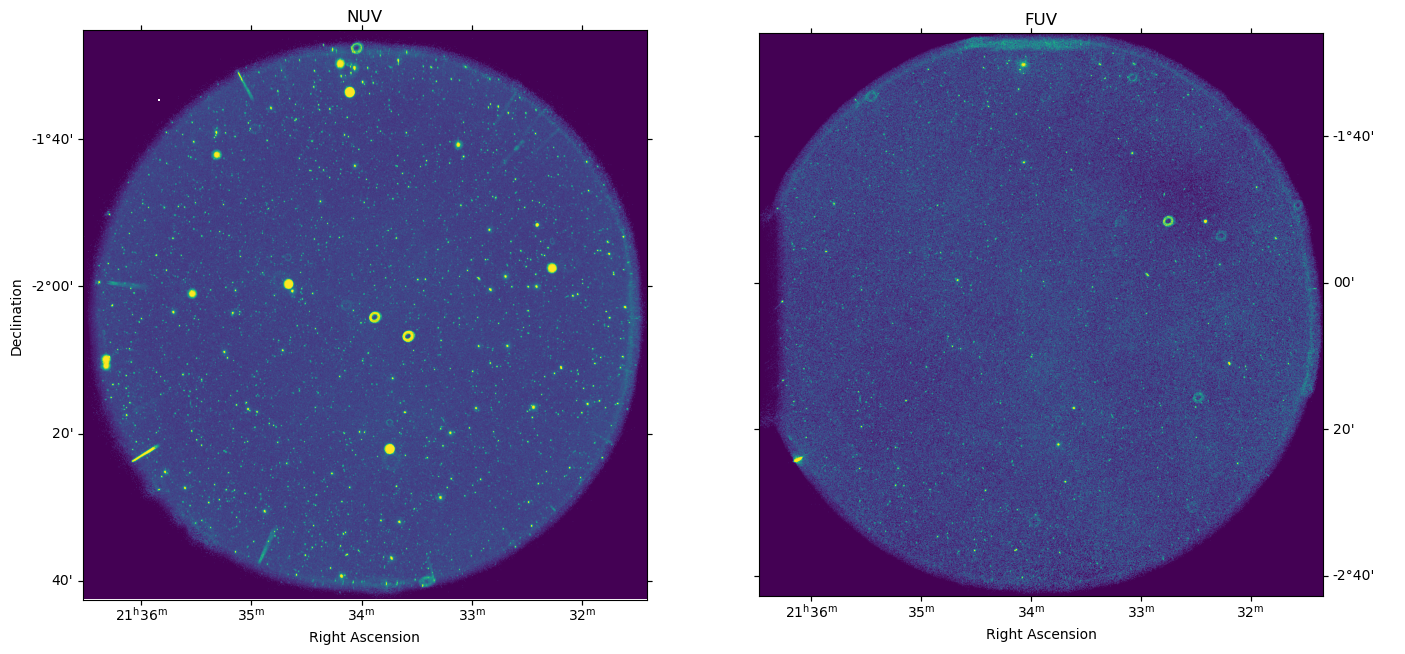

In [9]:
plt.figure(figsize=(16,8))

ax1 = plt.subplot(1,2,1, projection=image['NUV']['wcs'])
ax1.imshow(ZScaleInterval()(image['NUV']['count']), origin='lower')#, vmin=-100., vmax=2000.)
ax1.coords['ra'].set_axislabel('Right Ascension')
ax1.coords['dec'].set_axislabel('Declination')
ax1.set_title('NUV')

ax2 = plt.subplot(1,2,2, projection=image['FUV']['wcs'])
ax2.imshow(ZScaleInterval()(image['FUV']['count']), origin='lower')#, vmin=-2.e-4, vmax=5.e-4)
#ax2.coords['glon'].set_axislabel('Galactic Longitude')
#ax2.coords['glat'].set_axislabel('Galactic Latitude')
ax2.coords['ra'].set_axislabel('Right Ascension')
ax2.coords['dec'].set_axislabel(' ')
ax2.coords['dec'].set_axislabel_position('r')
ax2.coords['dec'].set_ticklabel_position('r')
ax2.set_title('FUV')

In [10]:
from gPhoton.coadd import make_shared_wcs, project_to_shared_wcs, bin_projected_weights

In [11]:
shared_wcs = make_shared_wcs((image['NUV']['wcs'],image['FUV']['wcs']))

In [12]:
proj_nuv = project_to_shared_wcs(nuv_image_fn,shared_wcs,1,apply_mask=False)
pimg_nuv = bin_projected_weights(proj_nuv['x'],proj_nuv['y'],proj_nuv['weight'],proj_nuv['imsz'])

In [13]:
proj_fuv = project_to_shared_wcs(fuv_image_fn,shared_wcs,1,apply_mask=False)
pimg_fuv = bin_projected_weights(proj_fuv['x'],proj_fuv['y'],proj_fuv['weight'],proj_fuv['imsz'])

Text(0.5, 1.0, 'FUV')

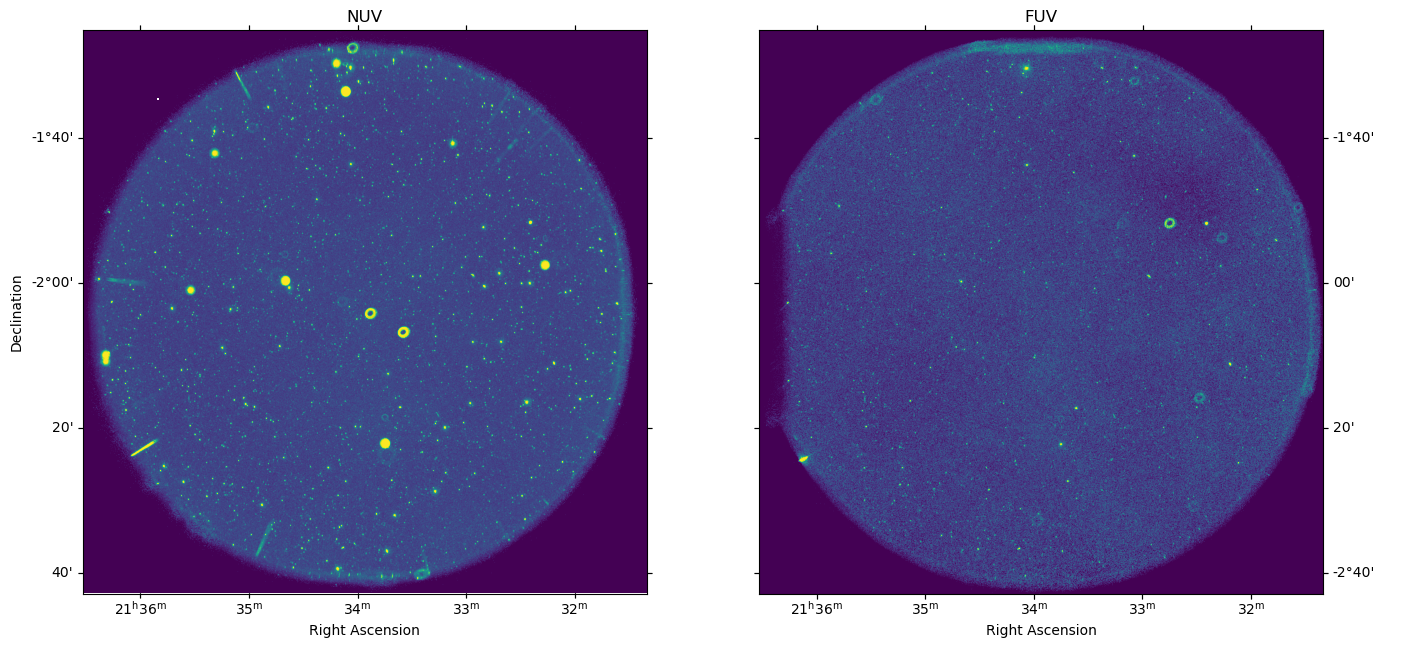

In [14]:
plt.figure(figsize=(16,8))

ax1 = plt.subplot(1,2,1, projection=shared_wcs)
ax1.imshow(ZScaleInterval()(pimg_nuv), origin='lower')#, vmin=-100., vmax=2000.)
ax1.coords['ra'].set_axislabel('Right Ascension')
ax1.coords['dec'].set_axislabel('Declination')
ax1.set_title('NUV')

ax2 = plt.subplot(1,2,2, projection=shared_wcs)
ax2.imshow(ZScaleInterval()(pimg_fuv), origin='lower')#, vmin=-2.e-4, vmax=5.e-4)
#ax2.coords['glon'].set_axislabel('Galactic Longitude')
#ax2.coords['glat'].set_axislabel('Galactic Latitude')
ax2.coords['ra'].set_axislabel('Right Ascension')
ax2.coords['dec'].set_axislabel(' ')
ax2.coords['dec'].set_axislabel_position('r')
ax2.coords['dec'].set_ticklabel_position('r')
ax2.set_title('FUV')

In [15]:
from IPython.display import Image

In [16]:
def make_gif(movie_array,fn_root,temp_dir,output_dir,overwrite = True,cmap="inferno",fps=8):
    gif_fn = f'{output_dir}{fn_root}.gif'
    if os.path.exists(gif_fn) and not overwrite:
        return gif_fn
    n = movie_array.shape[0]
    for i in tqdm.tqdm(range(n)):
        frame_fn = f'{temp_dir}{fn_root}_{str(i).zfill(2)}.png'
        if os.path.exists(frame_fn) and not overwrite:
            continue
        frame = movie_array[i,:,:]
        plt.figure(figsize=(8,8));
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.imshow(ZScaleInterval()(frame),cmap=cmap,origin="lower")
        plt.savefig(frame_fn)
        plt.close()
    if os.path.exists(f'{output_dir}{fn_root}.gif') and not overwrite:
        pass
    else:
        with imageio.get_writer(gif_fn, mode='I', fps=fps, loop=0) as writer:
            for i in tqdm.tqdm(range(n)):
                frame_fn = frame_fn = f'{temp_dir}{fn_root}_{str(i).zfill(2)}.png'
                image = imageio.imread(f'{frame_fn}')
                writer.append_data(image)
    return gif_fn

100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00, 48.47it/s]


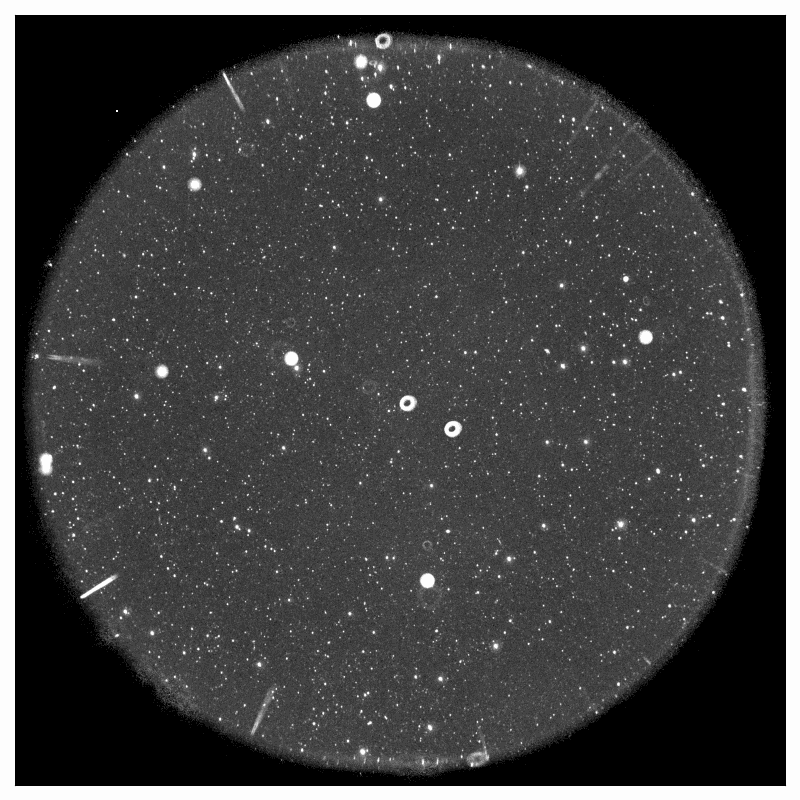

In [17]:
gif_fn = make_gif(np.stack([pimg_nuv,pimg_fuv]),
                  fn_root = 'e23456',
                  temp_dir = '/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/temp/e23456/',
                  output_dir = '/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/e23456/',
                  overwrite = True,cmap="Greys_r",fps=1)
display(Image(data=open(gif_fn,'rb').read(), format='gif'))

In [18]:
? imageio.get_writer

Signature:  imageio.get_writer(uri, format=None, mode='?', **kwargs)
Docstring:
get_writer(uri, format=None, mode='?', **kwargs)

Returns a :class:`.Writer` object which can be used to write data
and meta data to the specified file.

Parameters
----------
uri : {str, pathlib.Path, file}
    The resource to write the image to, e.g. a filename, pathlib.Path
    or file object, see the docs for more info.
format : str
    The format to use to write the file. By default imageio selects
    the appropriate for you based on the filename.
mode : {'i', 'I', 'v', 'V', '?'}
    Used to give the writer a hint on what the user expects (default '?'):
    "i" for an image, "I" for multiple images, "v" for a volume,
    "V" for multiple volumes, "?" for don't care.
kwargs : ...
    Further keyword arguments are passed to the writer. See :func:`.help`
    to see what arguments are available for a particular format.
File:      ~/mambaforge/envs/glcat/lib/python3.12/site-packages/imageio/v2.py
Type:    